In [1]:
import os
import sys

# From notebooks/ go one level up to the project root (where src/ and config.py live)
project_root = os.path.abspath("..")
if project_root not in sys.path:
    sys.path.append(project_root)

print("Project root:", project_root)
print("src in root?", os.path.isdir(os.path.join(project_root, "src")))
print("config in root?", os.path.isfile(os.path.join(project_root, "config.py")))


Project root: /Users/shirleywang/Documents/Codes/Git/regime_allocation_model-main
src in root? True
config in root? True


In [2]:
import matplotlib.pyplot as plt
import pandas as pd

from config import FILE_PATH_INPUTS, HMM_FEATURE_COLS, MACRO_COLS
from src.data_loader import load_macro_data
from src.regime_model import estimate_regimes
from src.factor_engine import (
    build_macro_panel,
    align_macro_with_regimes,
    compute_macro_state_means,
)

In [3]:
data = load_macro_data(FILE_PATH_INPUTS)

regime_result = estimate_regimes(
    data=data,
    feature_cols=HMM_FEATURE_COLS,
    span=3,
    n_components_list=(2, 3, 4),
    random_state=42,
)

post_smooth = regime_result["posteriors_smooth"]
state_mapping = regime_result["state_mapping"]

macro_panel = build_macro_panel(data, MACRO_COLS)

macro_panel_aligned, post_smooth_macro = align_macro_with_regimes(
    macro_panel,
    post_smooth,
)

print("Macro panel shape:", macro_panel_aligned.shape)
print("Regime posterior shape used for macro profiling:", post_smooth_macro.shape)

/Users/shirleywang/Documents/Codes/Git/regime_allocation_model-main/src/data_loader.py:29: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  data = data.set_index("Date").asfreq("M")


Macro panel shape: (229, 20)
Regime posterior shape used for macro profiling: (229, 4)


In [4]:
macro_state_df = compute_macro_state_means(
    macro_panel=macro_panel_aligned,
    post_smooth=post_smooth_macro,
    state_mapping=state_mapping,
)

print("\nMacro / policy / geo profile by regime (rows = regimes):")
print(macro_state_df.round(2))



Macro / policy / geo profile by regime (rows = regimes):
                         VIX_MonthlyAvg  HY OAS  IG OAS  DGS10  DGS3M  DGS2Y  \
Carry-Friendly                    15.40    6.33    1.17   2.73   1.57   1.86   
Defensive                         26.31    9.80    2.27   3.17   0.82   1.29   
Capital-Protection Mode           41.39   15.59    4.53   2.85   0.24   0.97   
Volatility Transition             18.95    7.90    1.54   3.18   0.71   1.27   

                         TED Spread  EFFR  5Y Breakeven  10Y Breakeven  \
Carry-Friendly                 0.31  1.61          2.00           2.11   
Defensive                      0.62  1.07          1.73           2.00   
Capital-Protection Mode        1.11  0.31          0.59           1.21   
Volatility Transition          0.35  0.82          1.86           2.12   

                         WTI Oil  PPI All Commodities  US EPU  \
Carry-Friendly             65.31               192.26  115.69   
Defensive                  79.04        

<Figure size 1200x600 with 0 Axes>

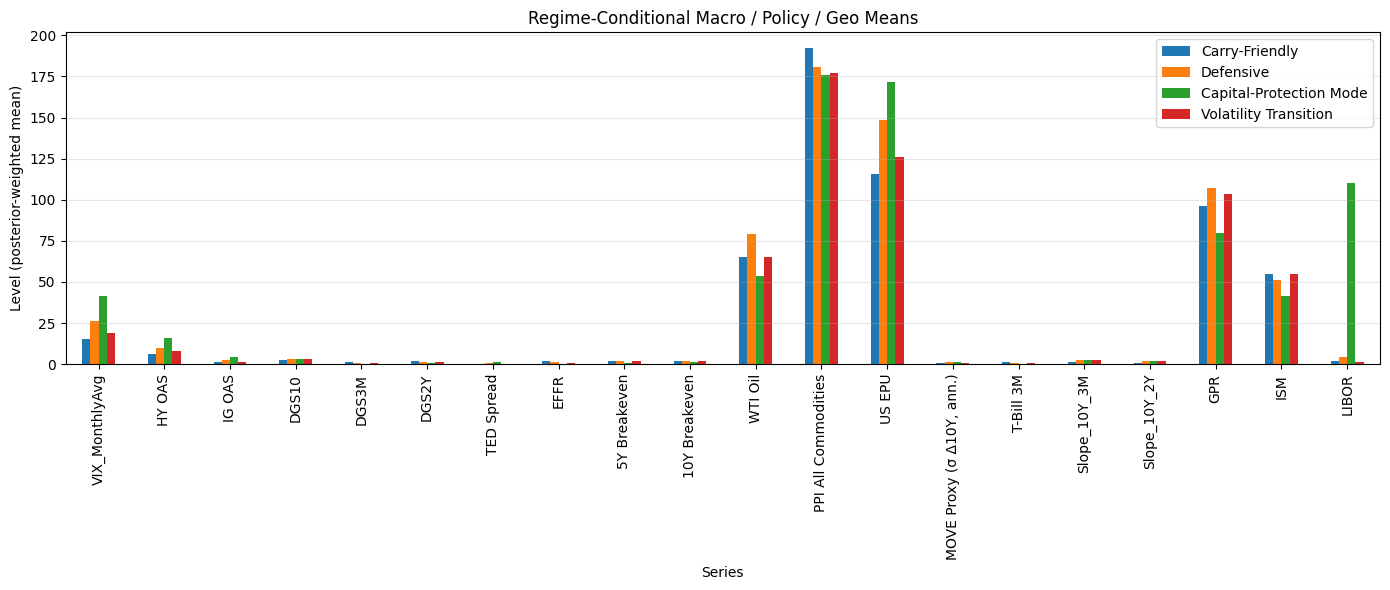

In [5]:
plt.figure(figsize=(12, 6))
macro_state_df.T.plot(kind="bar", figsize=(14, 6))

plt.title("Regime-Conditional Macro / Policy / Geo Means")
plt.xlabel("Series")
plt.ylabel("Level (posterior-weighted mean)")
plt.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()
